In [1]:
# Import libraries
import pandas as pd

In [2]:
# Load MIMIC-III datasets
admissions = pd.read_csv('ADMISSIONS.csv.gz')
diagnoses_icd = pd.read_csv('diagnoses_icd.csv.gz')
patients = pd.read_csv('PATIENTS.csv.gz')
prescriptions = pd.read_csv('PRESCRIPTIONS.csv.gz')

/var/folders/d5/szcrnrz90gd3spwg1pfkgxpw0000gn/T/ipykernel_25076/687380039.py:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv('PRESCRIPTIONS.csv.gz')


In [3]:
# Merge datasets to create a unified patient record
# Step 1: Merge diagnoses and prescriptions on HADM_ID and SUBJECT_ID
patients_data = pd.merge(diagnoses_icd,prescriptions, on = ['SUBJECT_ID','HADM_ID'], how = 'inner')

In [4]:
# Step 2: Add patient demographics
patients_data = pd.merge(patients_data,patients, on = ['SUBJECT_ID'], how = 'left')

In [5]:
# Step 3: Add admission details
admissions = admissions.drop(columns=['ROW_ID'])
patients_data = pd.merge(patients_data,admissions, on = ['SUBJECT_ID', 'HADM_ID'], how = 'left')

In [6]:
# Data Preprocessing
# Step 1: Filter relevant columns
patient_data = patients_data[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'DRUG', 'GENDER', 'DOB', 'ADMITTIME']]

In [7]:
# Step 2: Handle missing values
patient_data.dropna(subset=['ICD9_CODE','DRUG'], inplace = True)

/var/folders/d5/szcrnrz90gd3spwg1pfkgxpw0000gn/T/ipykernel_25076/3224446001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data.dropna(subset=['ICD9_CODE','DRUG'], inplace = True)


In [8]:
# Step 3: Convert diagnosis codes and medications to strings
patient_data['ICD9_CODE'] = patient_data['ICD9_CODE'].astype(str)
patient_data['DRUG'] = patient_data['DRUG'].astype(str)

/var/folders/d5/szcrnrz90gd3spwg1pfkgxpw0000gn/T/ipykernel_25076/2291980742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data['ICD9_CODE'] = patient_data['ICD9_CODE'].astype(str)
/var/folders/d5/szcrnrz90gd3spwg1pfkgxpw0000gn/T/ipykernel_25076/2291980742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data['DRUG'] = patient_data['DRUG'].astype(str)


In [9]:
# Step 5: Encode categorical variables (e.g., gender)
patient_data['GENDER'] = patient_data['GENDER'].map({'F': 0, 'M': 1})

/var/folders/d5/szcrnrz90gd3spwg1pfkgxpw0000gn/T/ipykernel_25076/1614580197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data['GENDER'] = patient_data['GENDER'].map({'F': 0, 'M': 1})


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from scipy.sparse import hstack

In [11]:
# Feature Engineering
# Step 1: Group by patient and admission to create a single record per admission
patient_features = patient_data.groupby(['SUBJECT_ID', 'HADM_ID']).agg({
    'ICD9_CODE': lambda x: ' '.join(x),  # Combine all diagnoses into a single string
    'DRUG': lambda x: ' '.join(x),  # Combine all medications into a single string
    'GENDER': 'first' #Take the first gender entry
}).reset_index()

In [12]:
# Step 2: Use TF-IDF to vectorize diagnoses and medications
tfidf = TfidfVectorizer(max_features=500)
diagnosis_vectors = tfidf.fit_transform(patient_features['ICD9_CODE'])

In [13]:
# Step 3: Encode medications as multi-labels
mlb = MultiLabelBinarizer()
medication_labels = mlb.fit_transform(patient_features['DRUG'])

In [14]:
# Step 4: Combine features into a single feature matrix
feature_matrix = hstack([diagnosis_vectors, patient_features[['GENDER']]])

In [15]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [16]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, medication_labels, test_size=0.2, random_state=42)

In [17]:
# Machine Learning Model (Random Forest)
# Train a multi-output classifier
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [18]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='micro')}")

Accuracy: 0.018520362441501542
F1 Score: 0.9286152212029976


In [19]:
# Deep Learning Model (Neural Network)
# Convert sparse matrices to dense arrays
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [20]:
import numpy as np 
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Compute class weights for each label
class_weights = []
for i in range(y_train.shape[1]):  # Iterate over each label
    unique_classes = np.unique(y_train[:, i])
    if len(unique_classes) == 1:  # Only one class present
        class_weights.append(1.0)  # Use default weight
    else:  # Two classes present
        weights = compute_class_weight('balanced', classes=unique_classes, y=y_train[:, i])
        class_weights.append(weights[1])  # Use weight for the positive class (1)
# Convert to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In [21]:
# Build a neural network
dl_model = Sequential([Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(medication_labels.shape[1], activation='sigmoid')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile the model
dl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

In [23]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
# Train the model with class weights
history = dl_model.fit(
    X_train_dense, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping], 
    class_weight=class_weights_dict)

Epoch 1/20
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0226 - loss: 0.4810 - val_accuracy: 0.0000e+00 - val_loss: 0.2583
Epoch 2/20
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0557 - loss: 0.2709 - val_accuracy: 0.0045 - val_loss: 0.2431
Epoch 3/20
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0949 - loss: 0.2521 - val_accuracy: 0.0722 - val_loss: 0.2328
Epoch 4/20
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1573 - loss: 0.2424 - val_accuracy: 0.0961 - val_loss: 0.2292
Epoch 5/20
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2431 - loss: 0.2374 - val_accuracy: 0.2491 - val_loss: 0.2266
Epoch 6/20
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3256 - loss: 0.2339 - val_accuracy: 0.5544 - val_loss: 0.2242
Epoch 7/20
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4257 - loss: 0.2306 - val_accuracy: 0.8077 - val_loss: 0.2219
Epoch 8/20
1005/1005 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5343 - loss: 0.228

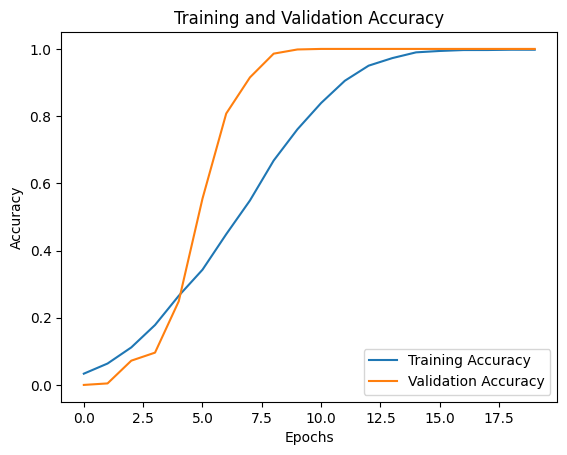

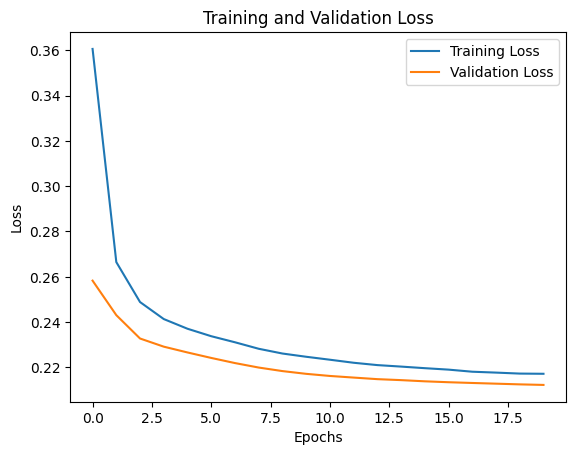

In [25]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Evaluate the model
loss, accuracy = dl_model.evaluate(X_test_dense, y_test)
print(f"Test Accuracy: {accuracy}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 1.0000 - loss: 0.2152
Test Accuracy: 1.0


In [27]:
# Make predictions
y_pred_dl = dl_model.predict(X_test_dense)
y_pred_dl_binary = (y_pred_dl > 0.5).astype(int)

314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


In [28]:
# Evaluate F1 score for the DL model
print(f"DL Model F1 Score: {f1_score(y_test, y_pred_dl_binary, average='micro')}")

DL Model F1 Score: 0.9288864184526042


In [29]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

precision = precision_score(y_test, y_pred_dl_binary, average='micro')
print(f"DL Model Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred_dl_binary, average='micro')
print(f"DL Model Recall: {recall}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_dl, average='micro') #use the non-binary predictions for roc_auc
print(f"DL Model ROC-AUC: {roc_auc}")

DL Model Precision: 0.9122453069677333
DL Model Recall: 0.9461459428320298
DL Model ROC-AUC: 0.9686786969359817


[[252321  45976]
 [ 27204 477939]]


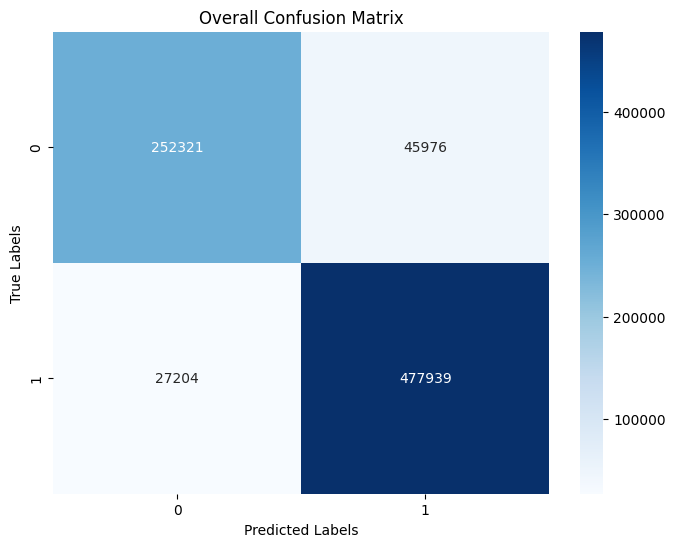

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# --- Confusion Matrix ---
# Calculate the overall confusion matrix (micro-averaged)
# Since this is multi-label, we need to flatten the arrays first.
y_test_flat = y_test.flatten()
y_pred_flat = y_pred_dl_binary.flatten()

conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


[[0.84587173 0.15412827]
 [0.05385406 0.94614594]]


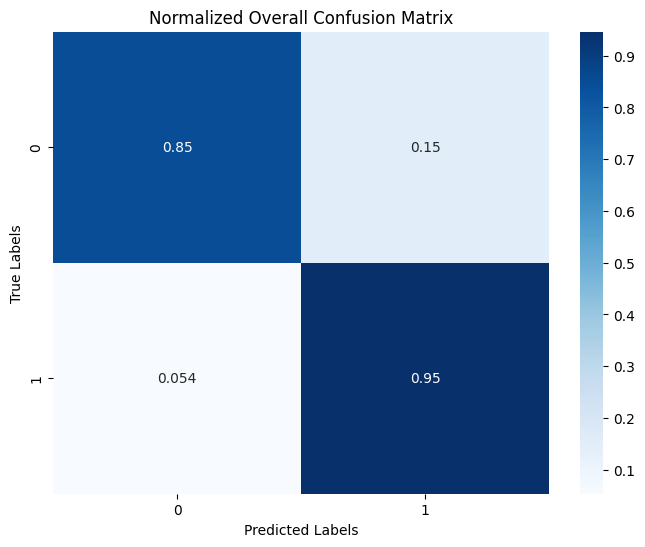

In [31]:
# --- Optional: Normalized Confusion Matrix ---
# To see the proportions rather than raw counts
conf_matrix_norm = confusion_matrix(y_test_flat, y_pred_flat, normalize='true')
print(conf_matrix_norm)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues')
plt.title('Normalized Overall Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
